# Import packages and data

In [18]:
%load_ext autoreload
%autoreload 2

In [19]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from scipy.optimize import fmin
import torch
import os, glob

from indentation.indentationset import IndentationSet
from indentation.processing.find_contact import findContact_minimum, findContact_blackMagic, findContact_blackMagic_CNN
from indentation.processing.signal import do_nothing, crop_afm_temp, crop_start, crop_end
from indentation.processing.calculate_parameters import parameter_youngs_modulus, parameter_defelection_sensitivity
from indentation.processing.plotting import plot_curve_parameters_bar, plot_instance_parameters_bar, plot_mean_force_curves
from indentation.ml.models import ConvClassifier_1, ConvClassifier_2

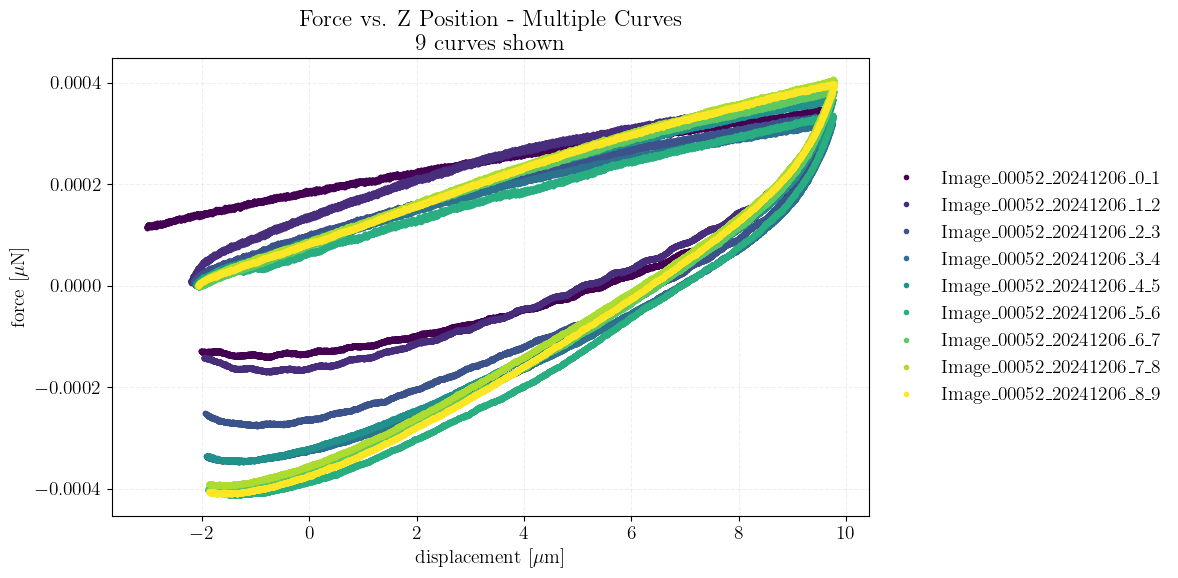

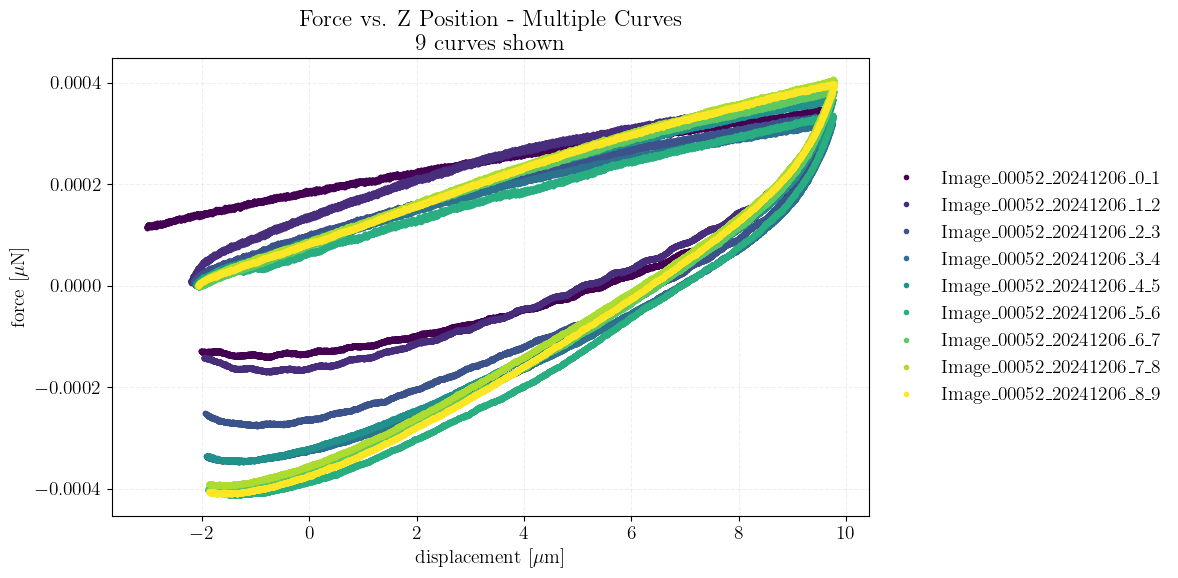

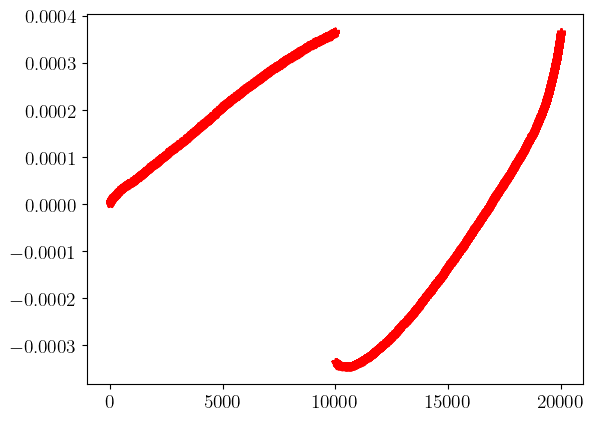

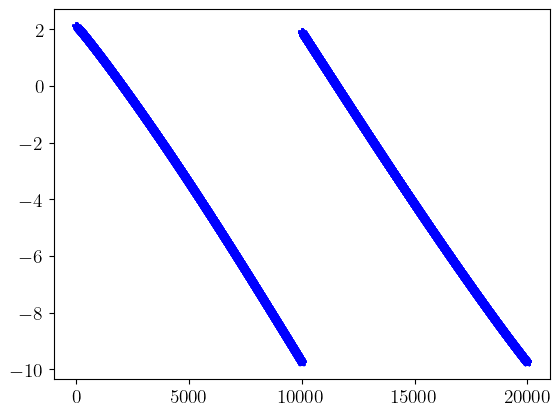

In [46]:
# paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\151124\air_calib3\*.txt")
# paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\glass_afm_041124_calib\*.txt")
# paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\2024_11_08\afm_pdms_35t1_liquid\*.txt")
# paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\2024_11_08\afm_glass_liquid_2\*.txt")
# paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\2024_11_08\afm_glass_liquid_1\*.txt")
# paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\2024_11_15\afm_rtv_liquid\*.txt")#RTV data
# paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\Immersed_afm_081124\*.txt") # on glass
# paths = glob.glob(r"E:\Group\File_Exchange\Paula_Havar\Pycharm project\txts\*.txt")
# paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\2024_11_29\afm_pdms35t1_ethanol_no2\*.txt")
# paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\2024_11_29\afm_pdms35t1_pbs_no5\*.txt")
# paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\2024_11_29\afm_pdms35t1_plasma_pbs_no3\*.txt")

# 49
#paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\2024_12_06\afm_colgel_glue1_pbs_500pN_10nN\*.txt")

# 50
#paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\2024_12_06\afm_colgel_glue1_pbs_50pN_1nN_1ums\*.txt")

# 51
#paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\2024_12_06\afm_colgel_glue1_pbs_250pn_1nN_2ums\*.txt")

# 52
paths = glob.glob(r"E:\Group\File_Exchange\Raoul_Paula\2024_12_06\afm_colgel_glue2_pbs_500pN_5nN_1ums\*.txt")



afm = IndentationSet(paths, exp_type="afm")

afm.plot_all(linestyle="")
afm.plot_all_raw(linestyle="")

# plt.figure()
# plt.plot(-afm.data[0]["raw"]["z"], afm.data[0]["raw"]["force"], 'r*')
# plt.show()

plt.figure()
plt.plot(afm.data[4]["raw"]["force"], 'r*')
plt.show()

plt.figure()
plt.plot(afm.data[4]["raw"]["z"], 'b*')
plt.show()

# Processing data

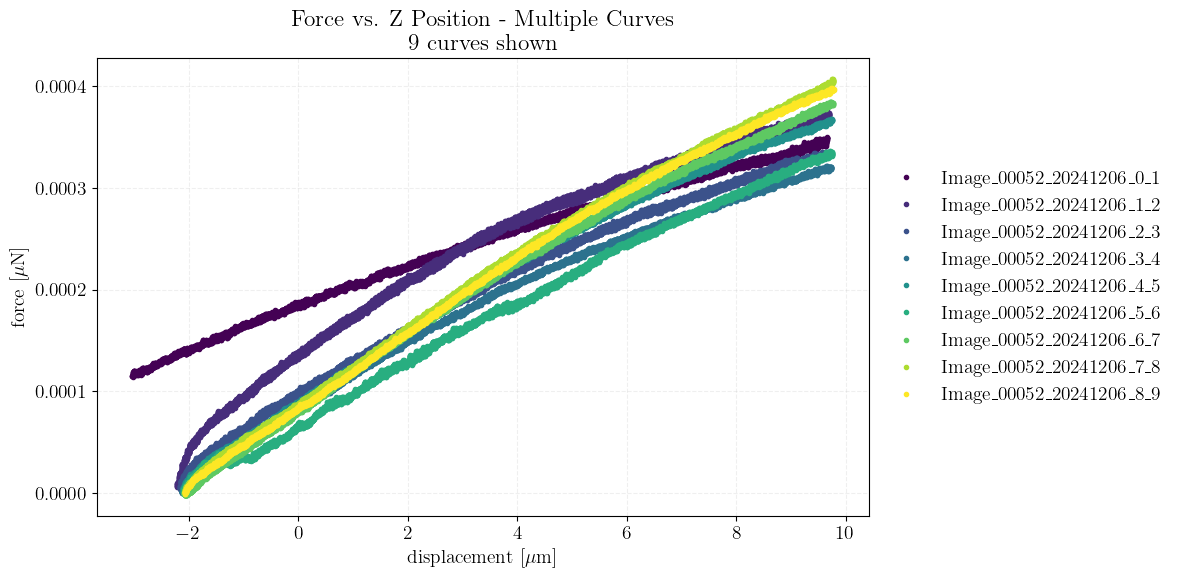

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Force vs. Z Position - Multiple Curves\n9 curves shown'}, xlabel='displacement [$\\mu$m]', ylabel='force [$\\mu$N]'>)

In [47]:
# processing_pl = [crop_afm_temp, findContact_minimum]
#processing_pl = [partial(crop_start, ix_start=5000), crop_afm_temp, findContact_blackMagic]
#processing_pl = [crop_afm_temp, findContact_blackMagic]
processing_pl = [crop_afm_temp]

afm.process_raw(processing_pl)
afm.plot_all(linestyle="")

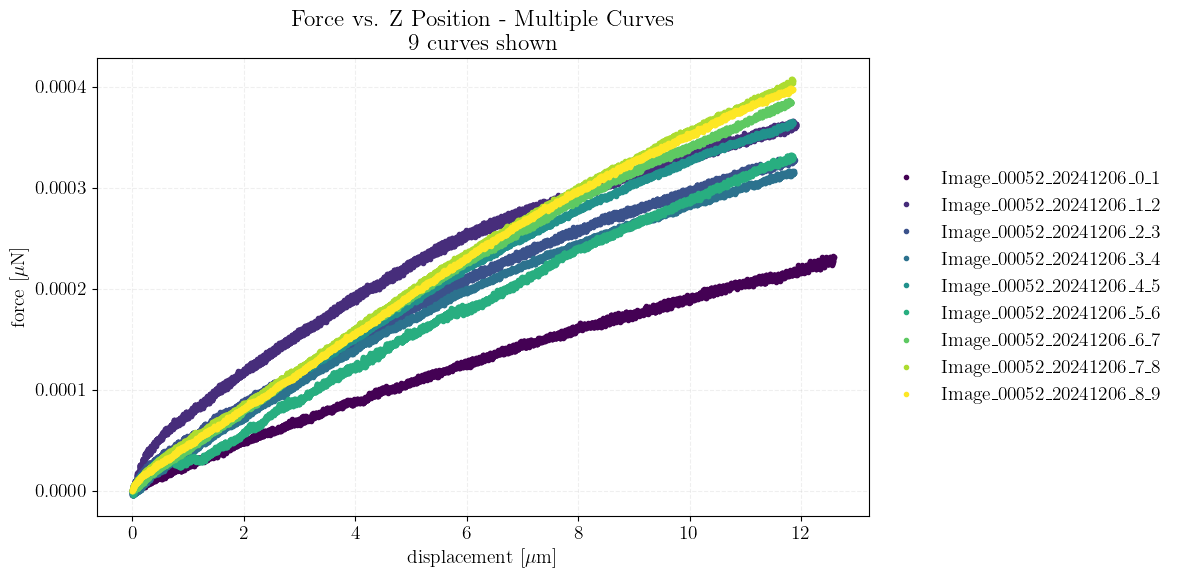

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Force vs. Z Position - Multiple Curves\n9 curves shown'}, xlabel='displacement [$\\mu$m]', ylabel='force [$\\mu$N]'>)

In [48]:
processing_pl = [crop_afm_temp, findContact_blackMagic]

afm.process_raw(processing_pl)
afm.plot_all(linestyle="")

Mean and std: 0.017771430062483558 0.010115048563204113


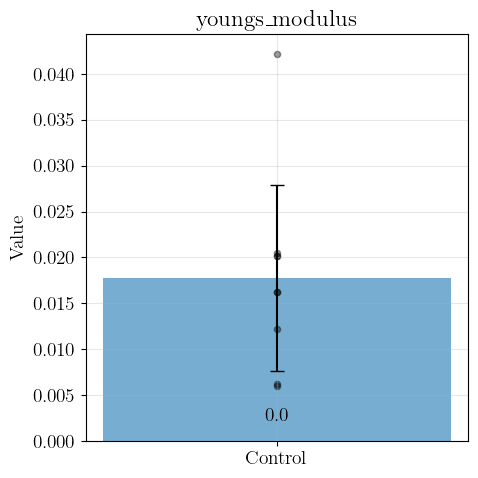

In [49]:
function_arguments = dict(radius=5, nu=0.5, cutoff=10, keyname="youngs_modulus")
afm.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)

plot_curve_parameters_bar(afm,
                         parameter_names=['youngs_modulus'],
                         labels=['Control'],
                         figsize=(5,5))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 54
0
11.499786376953125


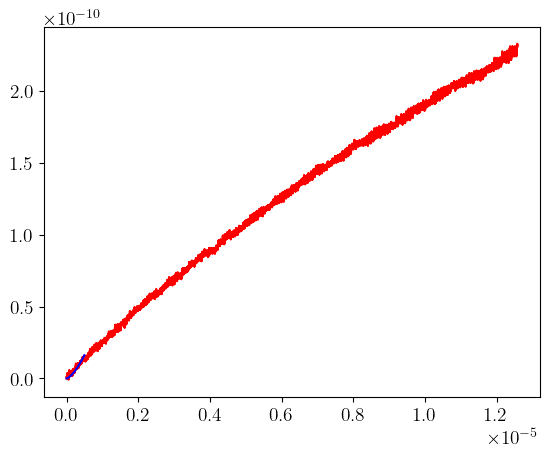

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 54
1
48.34747314453125


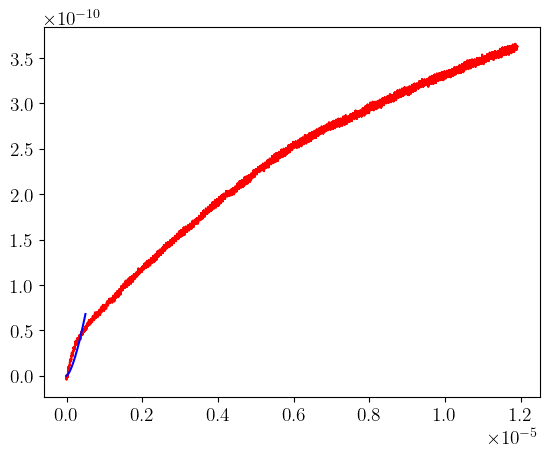

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 54
2
29.621219635009766


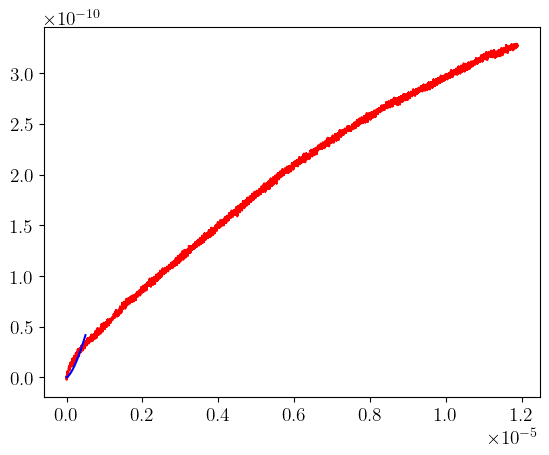

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 54
3
15.916919708251953


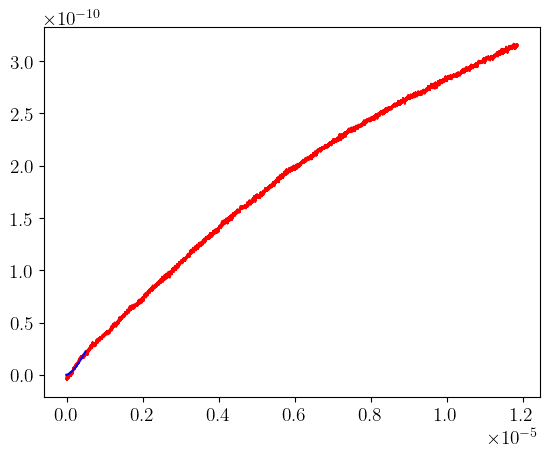

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 54
4
28.121089935302734


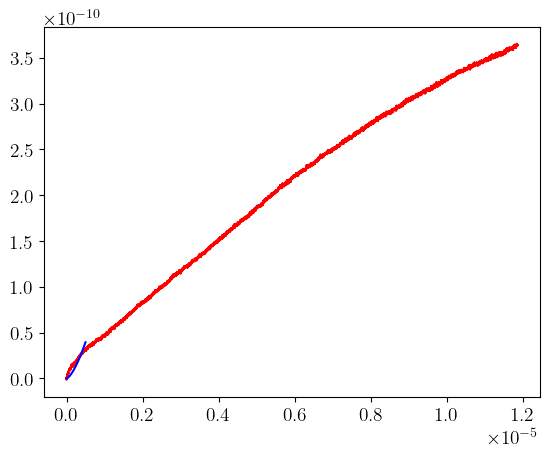

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 54
5
23.09427261352539


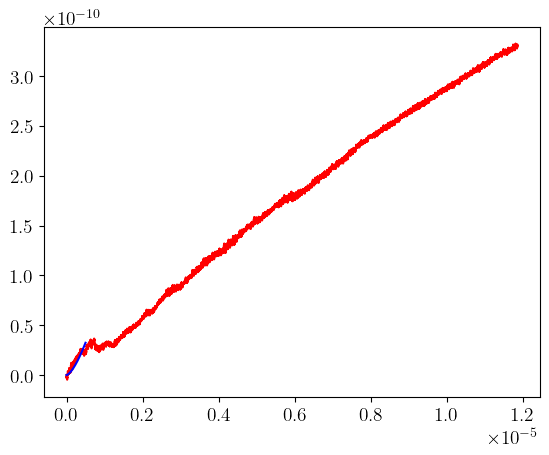

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 54
6
19.195842742919922


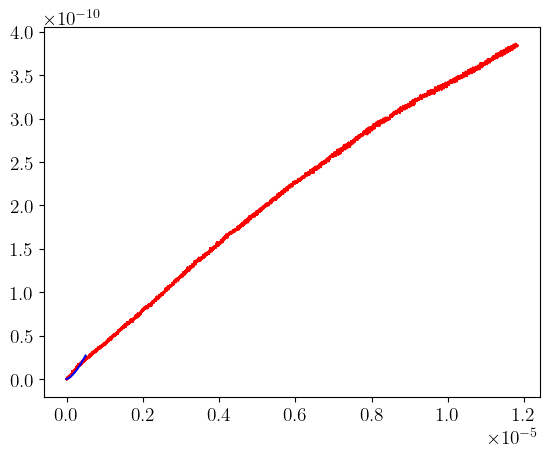

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 54
7
27.482032775878906


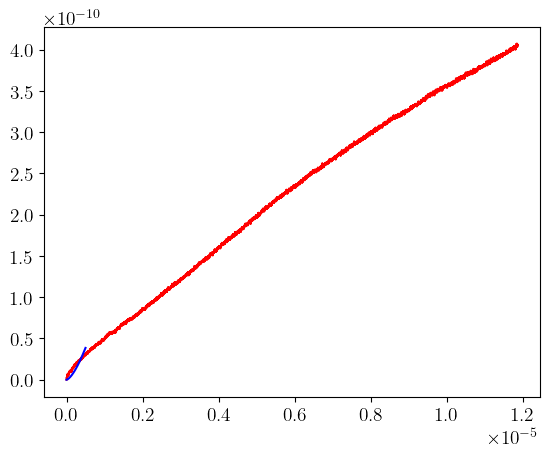

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 54
8
24.38201904296875


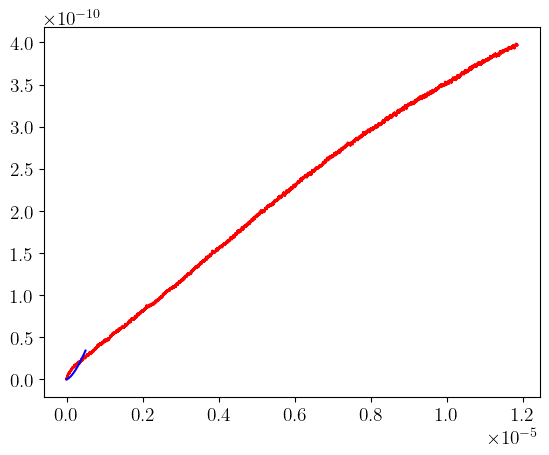

In [50]:
def hertzian(E, R, nu, z):
    hertz_F = 4.0 / 3.0 * E * np.sqrt(R) / (1 - nu*nu) * np.power(z, 3.0/2.0)
    
    return hertz_F

def sse(param, R, nu, F, z, cutoff):
    E = param
    ix = np.where(z > cutoff * R)[0][0]

    force = F[:ix]
    disp_z = z[:ix]
    
    hertz_F = hertzian(E, R, nu, disp_z)

    sse_value = np.sum((force-hertz_F)**2.0)

    return sse_value

for i in range(0, 9):
    initial_guess = 1e3
    R = 5 / 1e6
    nu = 0.5
    F = afm.data[i]["processed"]["force"] / 1e6
    z = -afm.data[i]["processed"]["z"] / 1e6
    cutoff = 0.10
    result = fmin(sse, initial_guess, args=(R, nu, F, z, cutoff))
    print(i)
    print(result[0])
    
    ix = np.where(z > cutoff * R)[0][0]
    hertz_fit = hertzian(result[0], R, nu, z[:ix])
    
    plt.figure()
    plt.plot(z, F, 'r-')
    plt.plot(z[:ix], hertz_fit, 'b-')
    plt.show()

C:\Users\paula\PythonCoding\indentation\indentation\processing\plotting.py:286: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


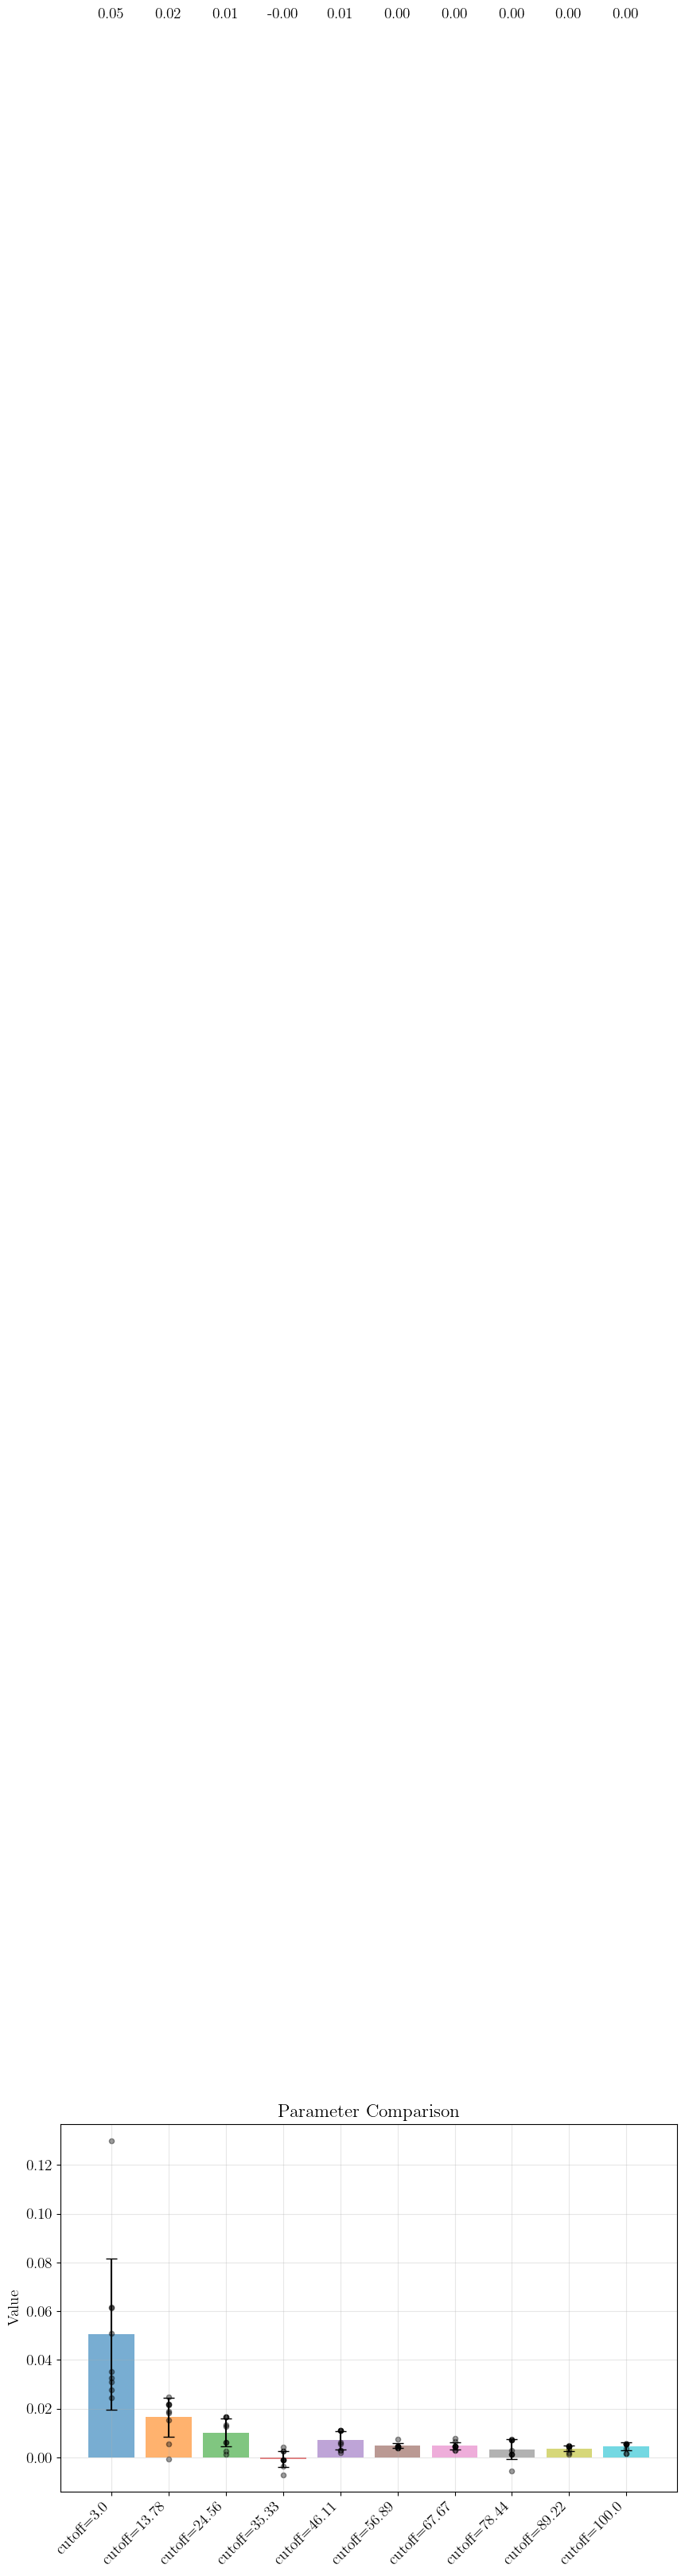

In [51]:
cutoffs = np.linspace(3, 100, 10)

for cutoff in cutoffs:
    function_arguments = dict(radius=5, nu=0.5, cutoff=cutoff, keyname="cutoff="+str(np.round(cutoff, 2)))
    afm.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)

plot_instance_parameters_bar(afm,
                         parameter_names=[*["cutoff="+str(np.round(cutoff, 2)) for cutoff in cutoffs]],
                         figsize=(10,6))

58.432449515586725
57.09483081384559
55.269405555368365
58.825003420531104
58.49225511176208
57.7134292374054
58.18200696329751
58.89549846045678
57.84910102597372
Mean and std: 57.86155334491414 1.0621187233312377


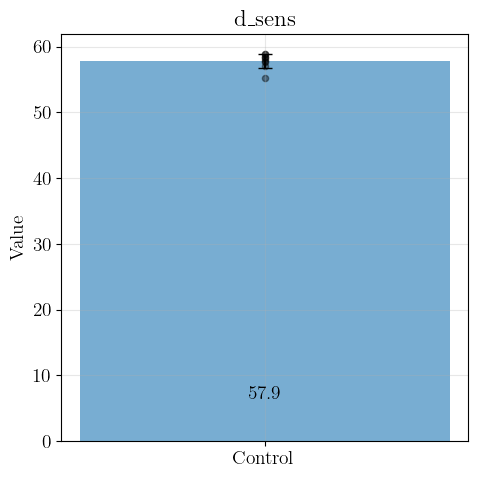

In [35]:
function_arguments = dict(keyname="d_sens")
fluidfm.calculate_curve_parameter(function=parameter_defelection_sensitivity)
plot_curve_parameters_bar(fluidfm,
                         parameter_names=["d_sens"],
                         labels=['Control'],
                         figsize=(5,5))